In [6]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import Image

from IPython.core.display import HTML
def header(text):
    raw_html = '<h4>' + str(text) + '</h4>'
    return raw_html

def box(text):
    raw_html = '<div style="border:1px dotted black;padding:2em;">'+str(text)+'</div>'
    return HTML(raw_html)

def nobox(text):
    raw_html = '<p>'+str(text)+'</p>'
    return HTML(raw_html)

def addContent(raw_html):
    global htmlContent
    htmlContent += raw_html
    
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [14]:
PDF('figures/Staggered-grid-2D.pdf',size=(600,500))

Figure 1. Sketch of a cell (top left) with the horizontal (red) and vertical (green) velocity nodes and the cell-centered node (blue). Definition of the normal vector to "surface" (segment) $S_{i+\frac{1}{2},j}$ and $S_{i,j+\frac{1}{2}}$ (top right). Sketch of uniform grid (bottom).

<h1>1. Derivation of 1D Transport Equation</h1>

<h2>1.1 1D Transport Without Diffusion</h2>

Consider a small control surface (cell) of dimensions $\Delta x\times\Delta y$ within which, we know the velocities on the surfaces $u_{i\pm\frac{1}{2},j}$ and $v_{i,j\pm\frac{1}{2}}$ and a quantity $\phi_{i,j}$ at the center of the cell. This quantity may be temperature, or the concentration of chemical specie. The variation in time of $\phi$ within the cell is equal to the amount of $\phi$ that is flowing in and out of the cell through the boundaries of cell. The velocity vector is defined as

$$
\vec{u}=u\vec{e}_x+v\vec{e}_y
$$

The fluxes of $\phi$ across the right-hand-side and left-hand-side vertical boundaries are, respectively:

$$
\int_{S_{i+1/2,j}}\phi(\vec{u}_{i+\frac{1}{2},j}\cdot\vec{n}_{i+\frac{1}{2},j})dy\text{ and }\int_{S_{i-1/2,j}}\phi(\vec{u}_{i-\frac{1}{2},j}\cdot\vec{n}_{i+\frac{1}{2},j})dy
$$

In the configuration depicted in Figure 1, the mass or heat variation is equal to the flux of $\phi$ entering the cell minus the flux exiting the cell, or:
$$
-\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}\Delta y + \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\Delta y \text{, when $\Delta y\rightarrow 0$}
$$

Assuming that there is no vertical velocity ($v=0$), this sum is equal to the variation of $\phi$ within the cell,

$$
\frac{\partial}{\partial t}\iint_{V_{i,j}}\phi dxdy\approx\frac{\partial \phi_{i,j}}{\partial t}\Delta x\Delta y \text{, when $\Delta x\rightarrow 0$ and $\Delta y\rightarrow 0$}
$$

yielding

$$
\frac{\partial \phi_{i,j}}{\partial t}\Delta x\Delta y=-\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}\Delta y + \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\Delta y\;,
$$

reducing to

$$
\frac{\partial \phi_{i,j}}{\partial t}=-\frac{\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j} - \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}}{\Delta x}\;.
$$

In the limit of $\Delta x\rightarrow 0$, we obtain the conservative form of the pure advection equation:

$$
\frac{\partial \phi}{\partial t}+\frac{\partial u\phi}{\partial x}=0
$$

In [141]:
import matplotlib.pyplot as plt #calls the plotting library hereafter referred as to plt


import numpy as np
import scipy
import scipy.optimize
import scipy.constants as sc

L = 10.
N = 200
dx = L/N
u_0 = 1.



phi = np.ones(N)
u = np.ones(N+1)
x_phi = np.linspace(dx/2.,L-dx/2.,N)
x_u = np.linspace(0.,L,N+1)

In [167]:
def init_simulation(u,phi):
    u *= u_0
    phi = 1.+np.cos(2.*np.pi*(x_phi-L/2)/(L/2.))
    xmask = np.where(np.abs(x_phi-L/2.) > L/4.)
    phi[xmask] = 0.
    return u,phi
#plt.plot(x_phi,phi)
#plt.show()

In [163]:

%%timeit 

flux0 = np.zeros(N+1)
for i in range(1,N):
    flux0[i] = 0.5*(phi[i-1]+phi[i])*u[i]




10000 loops, best of 3: 107 µs per loop


In [164]:
%%timeit 


flux1 = np.zeros(N+1)
flux1[1:N] = 0.5*(phi[0:N-1]+phi[1:N])*u[1:N]


The slowest run took 10.90 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.41 µs per loop


In [173]:
def compute_flux(a,v,N,t):
    f=np.zeros(N+1)
    #f[1:N] = 0.5*(a[0:N-1]+a[1:N])*v[1:N]
    f[1:N] = a[0:N-1]*v[1:N]
    #f[N] = a[N-1]*v[N]
    #f[0] = f[N]
    f[0] = 0.#np.sin(2*np.pi*t)*v[0]
    f[N] = f[N-1]
    return f

In [181]:
def flux_divergence(f,N,dx):
    df = np.zeros(N)
    df[0:N] = -(f[1:N+1]-f[0:N])/dx
    return df

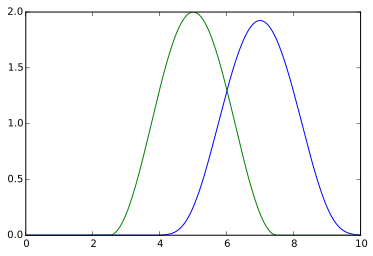

In [183]:
u,phi = init_simulation(u,phi)
phi_init = phi.copy()
rk_coef = np.array([0.5,1.])
number_of_iterations = 2000
dt = 0.001
flux = np.zeros(N+1)
divflux = np.zeros(N)
phiold = np.zeros(N)
t = 0.
for it in range (number_of_iterations):
    phiold = phi
    for irk in range(2):
        flux = compute_flux(phi,u,N,t)
        divflux = flux_divergence(flux,N,dx)
        phi = phiold+rk_coef[irk]*dt*divflux
    t += dt
plt.plot(x_phi,phi)
plt.plot(x_phi,phi_init)
plt.show()